In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_data.csv')
train = train[train.columns[1:]]
test = test[test.columns[1:]]
test.head()

,PassengerId,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Family_size,Title_1,Title_2,Title_3,Title_4,Emb_1,Emb_2,Emb_3
0,792,0,1,0.2000,0.050749,0,1,0,0.0,1,0,0,0,0,0,1
1,793,0,0,0.3500,0.135753,0,0,1,1.0,0,0,0,1,0,0,1
2,794,0,1,0.3500,0.059914,1,0,0,0.0,1,0,0,0,1,0,0
3,795,0,1,0.3125,0.015412,0,0,1,0.0,1,0,0,0,0,0,1
4,796,0,1,0.4875,0.025374,0,1,0,0.0,1,0,0,0,0,0,1


In [3]:
features = train.columns[2:]
target = ['Survived']
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

In [6]:
features

Index(['Sex', 'Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Family_size',
       'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Emb_1', 'Emb_2', 'Emb_3'],
      dtype='object')

## Estimating a simple classifier

In [16]:
# Estimate model using training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [17]:
# Check model accuracy using test data
model.score(X_test, y_test)

0.83

In [18]:
# Confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[57,  7],
       [10, 26]])

In [19]:
# Calculate precision, recall, and f-score
precision_recall_fscore_support(y_test, y_pred, average='weighted')

(0.8281139755766621, 0.83, 0.8282509127115831, None)

In [20]:
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

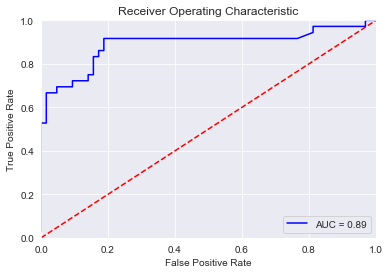

In [21]:
import seaborn as sns
sns.set_style('darkgrid')

# And plot using matplotlib
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This ROC-curve looks quite promising already, and with an AUC-value of 0.89 we can already say that this model is quite good at predicting survivors.

## Tuning algorithm parameters
Let's see if we can improve the model performance by tweaking the following parameters:
* n_estimators 
* early_stopping_rounds
* learning rate

In [22]:
model_2 = XGBClassifier(n_estimators=1000)
model_2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

predictions_2 = model_2.predict(X_test)

In model_2 we only added n_estimators and earl_stopping_rounds. What happens if we tweak the model a bit more with two different learning rates:
* Learning rate = 0.05
* Learning rate = 0.01

In [23]:
model_3 = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_3.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

predictions_3 = model_3.predict(X_test)

In [24]:
model_4 = XGBClassifier(n_estimators=1000, learning_rate=0.01)
model_4.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

predictions_4 = model_4.predict(X_test)

### Comparison simple classifier with 'tweaked' models


In [25]:
# Calculate precision, recall, and f-score for all three new models, starting with model_2
precision_recall_fscore_support(y_test, predictions_2, average='weighted')

(0.86, 0.86, 0.86, None)

In [26]:
precision_recall_fscore_support(y_test, predictions_3, average='weighted')

(0.86, 0.86, 0.86, None)

In [27]:
precision_recall_fscore_support(y_test, predictions_4, average='weighted')

(0.86, 0.86, 0.86, None)

So far, we see no improvements by tweaking the learning rate, so let's continue and compare the simple classifier and model_2.

In [29]:
# calculate the fpr and tpr for all thresholds of the classification for the three new models
# Model_2
probs_2 = model_2.predict_proba(X_test)
preds_2 = probs_2[:,1]
fpr_2, tpr_2, threshold_2 = roc_curve(y_test, preds_2)
roc_auc_2 = auc(fpr_2, tpr_2)

We could show this graph separately but let's compare the graph we showed earlier for the simple classifier with model_2 side by side.

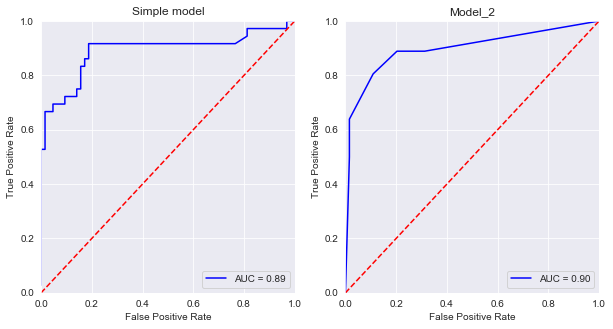

In [34]:
sns.set_style('darkgrid')

plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Simple model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(1, 2, 2)
plt.title('Model_2')
plt.plot(fpr_2, tpr_2, 'b', label = 'AUC = %0.2f' % roc_auc_2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Conclusion
With some simple adjustments we already saw an increase in precision, recall, and F1-score (all 0.86). In addition, the AUC-value improved slightly to 0.9. All minor improvements, but these could have a larger impact when dealing with data that is not as nice and clean as this dataset.<br>
<br>
Note, these were not the biggest modifications but made an impact nonetheless. Adjusting learning rate did not seem to improve the model that much more. All in all we can see that it can pay off to calibrate your model and see what gives the best performance.<br>

